### **Load Libraies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Numpy & matplotlib for notebooks
%pylab inline

# Pandas for data analysis and manipulation
import pandas as pd

# Sklearn
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron classifier which optimizes the log-loss function using LBFGS or sdg.
from sklearn.model_selection import train_test_split # to split arrays or matrices into random train and test subsets
from sklearn.model_selection import KFold # K-Folds cross-validator providing train/test indices to split data in train/test sets.
from sklearn.decomposition import PCA, TruncatedSVD # Principal component analysis (PCA); dimensionality reduction using truncated SVD.
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts
from sklearn.metrics import roc_auc_score as roc # Compute Area Under the Receiver Operating Characteristic Curve from prediction scores
from sklearn.metrics import roc_curve, auc # Compute ROC; Compute Area Under the Curve (AUC) using the trapezoidal rule
from sklearn.model_selection import cross_val_score

# Matplotlib
import matplotlib # Data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Seaborn
import seaborn as sns # Statistical data visualization (based on matplotlib)

Populating the interactive namespace from numpy and matplotlib


In [3]:
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
# Joblib
import joblib # To save models

In [4]:
arraypath = '/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/'
modelpath='/content/drive/MyDrive/Community Help /Abuse Text classification/Models/'
datapath='/content/drive/MyDrive/Community Help /Abuse Text classification/Data/'

### **Data Preparion**

In [5]:
train_data = pd.read_csv(datapath+'df_Text_Abuse_final_unique.csv')
train_data.drop(['Unnamed: 0'],
  axis='columns', inplace=True)
train_data_1=train_data[train_data["CATEGORY_CLASS"]=="ABUSE"]
train_data_2=train_data[train_data["CATEGORY_CLASS"]=="NON ABUSE"]
train_data_2=train_data_2.sample(n=48000, random_state=42)
train_data_1.shape,train_data_2.shape

((48602, 2), (48000, 2))

In [6]:
train_data = pd.concat([train_data_1, train_data_2], axis=0)
train_data.shape

(96602, 2)

In [7]:
X = []
# the genders
y = []
# lengths of X elements
X_len = []
for index, row in train_data.iterrows():
    X.append(row["CONTENT"])
    X_len.append([len(row["CONTENT"])])
    y.append(row["CATEGORY_CLASS"])
clean_train_subreddits = [xs.lower() for xs in X]

#### **Help Methods & Data Cleaning**

In [8]:
# preprocessing functions
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)

# remove words that end with one or more identical letters
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

def remove_allcaps(text):
    caps = re.compile(r'([^a-z0-9()<>\'`\-]){2,}')
    return caps.sub(r'ALLCAPS', text)

def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    return smiley.sub(r'SMILE', text)

def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [9]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [10]:
# tags Part of Speech (POS), because teh lemmatizer needs it
tag_map = defaultdict(lambda : wn.NOUN)
# wn does a grammatical analysis
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
# create lemmatizer
word_Lemmatized = WordNetLemmatizer()

def review_to_words(raw_body):
    # remove html tags
    body_text = BeautifulSoup(raw_body).get_text()
    #letters_only = re.sub("[^a-zA-Z]", " ", body_text)
    # lowercase all text
    words = body_text.lower()
    # remove urls
    text = remove_URL(words)
    # remove numbers
    text = remove_number(text)
    # remove smiles
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    text = remove_elongated_words(text)
    words = remove_repeat_punct(text)
    # tokenizes and pass to lemmatizer, which lemmatizes taking tags into account (see before)
    words = word_tokenize(words)
    # we don't remove stop words, because doing it on combination with removing the 40 (trial & error estimated parameter) most utilized words (see below) decreases performance
    #stops = set(stopwords.words("english"))
    #meaningful_words = [w for w in words if not w in stops]
    Final_words = []
    for word, tag in pos_tag(words):
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # returns lemmatized texts as strings
    return( " ".join(Final_words))

In [11]:
clean_train_comments = [review_to_words(x) for x in X]

<ipython-input-10-1e68d722f9d6>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  body_text = BeautifulSoup(raw_body).get_text()
<ipython-input-10-1e68d722f9d6>:12: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  body_text = BeautifulSoup(raw_body).get_text()


In [12]:
joblib.dump(clean_train_comments, arraypath+'clean_train_comments_abuse_mlp.pkl')
joblib.dump(X_len, arraypath+'X_len_abuse_mlp.pkl')
joblib.dump(y, arraypath+'y_abuse_mlp.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/y_abuse_mlp.pkl']

### **CountVectorizer**

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer # Il CountVectorizer ha performato meglio
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word",
                             max_features = 5000)
# converts in np array
train_data_features = vectorizer.fit_transform(clean_train_comments).toarray()


print(train_data_features.shape)
# print vocabulary
vocab = vectorizer.get_feature_names_out()
###print(vocab)
import numpy as np

# counts how many times a word appearco
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)

    # removes the 40 most utilized words
for _ in range(40):
    index = np.argmax(dist)
    train_data_features = np.delete(train_data_features, index, axis = 1)

train_data_features.shape

# np array
s = np.concatenate((train_data_features,np.array(X_len)),axis = 1)

# 5000 rows (one per author),  and 2000-40+1 (X_len) features
s.shape

# un np.array
y = np.array(y)

In [24]:
#from sklearn.feature_extraction.text import TfidfVectorizer # Il CountVectorizer ha performato meglio
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer2 = CountVectorizer(analyzer = "word",
                             max_features = 4961)
# converts in np array
train_data_features = vectorizer2.fit_transform(clean_train_comments).toarray()


print(train_data_features.shape)
# print vocabulary
#vocab = vectorizer.get_feature_names_out()
###print(vocab)


# counts how many times a word appearco
#dist = np.sum(train_data_features, axis=0)

#for tag, count in zip(vocab, dist):
    #print(count, tag)
    #pass

    # removes the 40 most utilized words
#for _ in range(40):
    #index = np.argmax(dist)
    #train_data_features = np.delete(train_data_features, index, axis = 1)

train_data_features.shape

# np array
s = np.concatenate((train_data_features,np.array(X_len)),axis = 1)

# 5000 rows (one per author),  and 2000-40+1 (X_len) features
s.shape
print(s.shape)
# un np.array
#y = np.array(y)

(96602, 4961)
(96602, 4962)


In [25]:
joblib.dump(vectorizer2, arraypath+'vectorizer_abuse_mlp.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/vectorizer_abuse_mlp.pkl']

### **MLP Classifier**

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical,plot_model
le=LabelEncoder()
lbls=le.fit_transform(y)
classes=list(le.classes_)
classes=[str(c) for c in classes]
lbls=to_categorical(lbls,num_classes=len(classes))
joblib.dump(lbls, arraypath+'lbls_MLP.pkl')
joblib.dump(classes, arraypath+'classes_abuse_mlp.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/classes_abuse_mlp.pkl']

In [ ]:
# Split the data for training
X1, X_valid, Y1, y_valid = train_test_split(s, lbls,
                                                      train_size=0.8, test_size=0.1,
                                                      random_state=0,stratify = lbls)


In [ ]:
X1.shape,X_valid.shape,Y1.shape,y_valid.shape

((77281, 4961), (9661, 4961), (77281, 2), (9661, 2))

In [ ]:
# Split the data for training
X_train, X_text, y_train, y_text = train_test_split(X1, Y1,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0,stratify = Y1)

In [ ]:
X_train.shape,X_text.shape,y_train.shape,y_text.shape

((61824, 4961), (15457, 4961), (61824, 2), (15457, 2))

In [ ]:
joblib.dump(X_text, arraypath+'X_text_MLP.pkl')
joblib.dump(y_text, arraypath+'y_text_MLP.pkl')

joblib.dump(X_valid, arraypath+'X_valid_MLP.pkl')
joblib.dump(y_valid, arraypath+'y_valid_MLP.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/NumPyArrays/y_valid_MLP.pkl']

In [ ]:
# Define MLP Classifier:
## Activation function for the hidden layer: "rectified linear unit function"
## Solver for weight optimization: "stochastic gradient-based optimizer"
## Alpha: regularization parameter
## Learning rate schedule for weight updates: "gradually decreases the learning rate at each time step t using an inverse scaling exponent of power_t"
## Verbose: "True" in order to print progress messages to stdout.
## Early stopping: "True" in order to use early stopping to terminate training when validation score is not improving. It automatically sets aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.

mlpClf = MLPClassifier(activation= 'relu', solver = 'adam',
                       alpha = 0.05, learning_rate = 'invscaling', verbose = True,
                       early_stopping = True, max_iter = 400, random_state=0)

# Model fit
mlpClf.fit(X_train, y_train)

# Prediction
y_score = mlpClf.predict_proba(X_valid)[:,1]


Iteration 1, loss = 1.12482388
Validation score: 0.819343
Iteration 2, loss = 0.89134517
Validation score: 0.828239
Iteration 3, loss = 0.81418979
Validation score: 0.840854
Iteration 4, loss = 0.76833817
Validation score: 0.845383
Iteration 5, loss = 0.77472883
Validation score: 0.843118
Iteration 6, loss = 0.74974146
Validation score: 0.840854
Iteration 7, loss = 0.74346976
Validation score: 0.821608
Iteration 8, loss = 0.73211991
Validation score: 0.841016
Iteration 9, loss = 0.74815728
Validation score: 0.851367
Iteration 10, loss = 0.71793347
Validation score: 0.848617
Iteration 11, loss = 0.70752282
Validation score: 0.855248
Iteration 12, loss = 0.69495508
Validation score: 0.846676
Iteration 13, loss = 0.67589515
Validation score: 0.842633
Iteration 14, loss = 0.66711048
Validation score: 0.854925
Iteration 15, loss = 0.66826437
Validation score: 0.857027
Iteration 16, loss = 0.66898453
Validation score: 0.840854
Iteration 17, loss = 0.65676019
Validation score: 0.850235
Iterat

In [ ]:
print(roc(y_valid.argmax(axis=1),y_score))

0.9315181418432421


In [ ]:
ytest_score = mlpClf.predict_proba(X_text)[:,1]

In [ ]:
print(roc(y_text.argmax(axis=1),ytest_score))

0.929444303247289


In [ ]:
np.save(modelpath+'ytest_score.csv',ytest_score)
np.save(modelpath+'yval_score.csv',y_score)
joblib.dump(mlpClf, modelpath+'mlpClf.pkl')

['/content/drive/MyDrive/Community Help /Abuse Text classification/Models/mlpClf.pkl']

### **ROC Visualization**

#### Validation Data

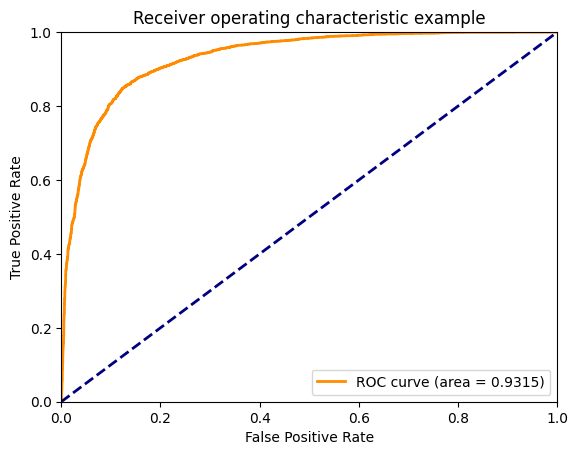

In [ ]:
# ROC Curve for validation data
fpr, tpr, thresholds = roc_curve(y_valid.argmax(axis=1), y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Test Data

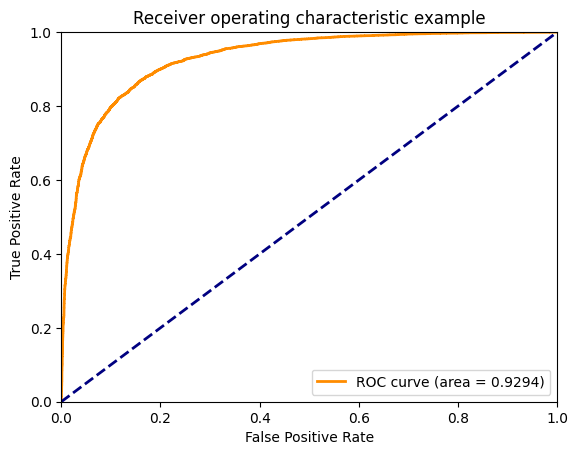

In [ ]:
# ROC Curve for Text data
fpr, tpr, thresholds = roc_curve(y_text.argmax(axis=1), ytest_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()